# Deep Convolutional Generative Adversarial Network

## Overview
이번 실습에서는 DCGAN을 현하고, MNIST dataset을 이용하여 학습해보록 하겠습니다.

2016년에 제안된 DCGAN(Deep Convolution GAN)은 가장 기본적인 GAN 구조 중 하나입니다.

- 이 실습자료는 [GAN-Tutorial](https://github.com/Yangyangii/GAN-Tutorial)을 기반으로 작성되었습니다.

### Setup

우선, DCGAN 구현을 위해 필요한 패키지들을 설치하고 import하도록 하겠습니다.

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

import numpy as np
import datetime
import os, sys

from matplotlib.pyplot import imshow, imsave

DEVICE = torch.device('cuda')

### Load and prepare the dataset

이번 실습에서 사용할 MNIST dataset을 다운로드하고, 로드하겠습니다.

In [2]:
batch_size = 64

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5],
                                std=[0.5])]
)

mnist = datasets.MNIST(root='./data/', train=True, transform=transform, download=True)
data_loader = DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True, drop_last=True)

## DCGAN 구현

지금부터 DCGAN 모델을 구현하도록 하겠습니다.

### 1. Generator

Convolutional Auto Encoder의 Decoder와 마찬가지로 transposed convolution을 활용하여, latent $z$로부터 MNIST dataset 이미지를 생성하는 Generator 모델을 만들어보겠습니다.

실제 DCGAN의 Generator는 64x64 이미지를 생성하지만, 이번 실습에서는 MNIST dataset의 사이즈에 맞추어 100차원 latent vector $z$로부터 28x28 이미지를 생성해보도록 하겠습니다.

모델의 구조는 다음과 같습니다.  

1. **Input**: latent $z$, [batch, 100]  

2. **FC**: [batch, 100] → [batch, 512x4x4=8192]
3. **ReLU**
4. **Reshape**: [batch, 512x4x4=8192] → [batch, 512, 4, 4]
5. **ConvTranspose2d**: [batch, 512, 4, 4] → [batch, 256, 7, 7], kernel_size=3, stride=2 padding=1, bias=False
6. **BatchNorm2d**: channel 256
7. **ReLU**
8. **ConvTranspose2d**: [batch, 256, 7, 7] → [batch, 128, 14, 14], kernel_size=4, stride=2, padding=1, bias=False
9. **BatchNorm2d** : channel 128
10. **ReLU**
11. **ConvTranspose2d**: [batch, 128, 14, 14] → [batch, 1, 28, 28], kernel_size=4, stride=2, padding=1, bias=False
12. **Tanh**


Q. 왜 마지막 layer는 Tanh를 사용할까?


In [4]:
class Generator(nn.Module):
    """
        Convolutional Generator for MNIST
    """
    def __init__(self, input_size=100):
        super(Generator, self).__init__()
        ################ ToDo ##################
        self.fc = nn.Sequential(
            # input : input size, output : 4x4x512
            nn.Linear(input_size, 512 * 4 * 4), # batch,100 -> batch,512*4*4
            nn.ReLU()
        )
        self.conv = nn.Sequential(
            # input: 4x4, output: 7x7
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # input: 7x7, output: 14x14
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # input: 14x14, output: 28x28
            nn.ConvTranspose2d(128, 1, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )
        #########################################

    def forward(self, z):
        x = z.view(z.size(0), -1)
        x = self.fc(x)
        x = x.view(x.size(0), 512, 4, 4)
        x = self.conv(x)
        return x

In [5]:
G = Generator().to(DEVICE)

아직 학습이 되지 않은 Generator를 이용하여 random sampling된 latent vector로부터 이미지를 생성해보겠습니다.

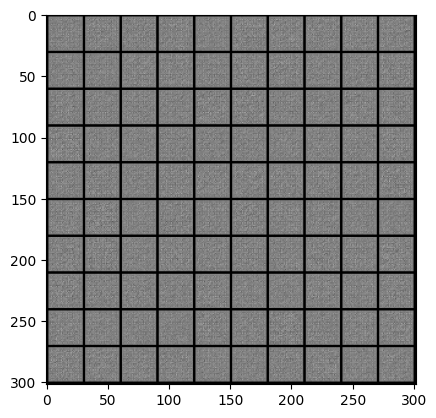

In [6]:
from torchvision.utils import make_grid

G.eval()

n_samples = 100

with torch.no_grad():
  z = torch.randn(n_samples, 100).to(DEVICE)
  x_hat = G(z)

img = make_grid(x_hat, nrow=10, normalize=True, value_range=(-1., 1.)).permute(1, 2, 0).cpu().data.numpy()
imshow(img, cmap='gray')

### 2, Discriminator

Generator가 생성한 이미지의, real/fake 여부를 구분하는 Discriminator를 구현해보도록 하겠습니다.

모델의 구조는 다음과 같습니다.  

1. **Input**: image $x$, [batch, 28, 28, 1]  
2. **Conv2d**: [batch, 1, 28, 28] → [batch, 512, 14, 14], kernel_size=3, stride=2, padding=1, bias=False
3. **BatchNorm2d**
4. **LeakyReLU**  
5. **Conv2d**: [batch, 512, 14, 14] → [batch, 256, 7, 7], kernel_size=5
6. **BatchNorm2d**
7. **LeakyReLU**
8. **Conv2d**: [batch, 256, 7, 7] → [batch, 128, 4, 4],
9. **BatchNorm2d**
10. **LeakyReLU**
11. **AvgPool2d**
12. **reshape**: [batch, 128, 4, 4] → [batch, 128x4x4=2048],
13. **Linear**: [batch, 128x4x4=2048] → [batch, 1]
14. **Sigmoid**
  
Q. 왜 마지막 layer는 sigmoid 일까?

In [7]:
class Discriminator(nn.Module):
    """
        Convolutional Discriminator for MNIST
    """
    def __init__(self, in_channel=1, num_classes=1):
        super(Discriminator, self).__init__()
        ################ ToDo ##################

        self.conv = nn.Sequential(
            # input: 28x28, output: 14x14
            nn.Conv2d(in_channel, 512, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2), # arg : hyperparameter -> 기울기
            # input: 14x14, output: 7x7
            nn.Conv2d(512, 256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            # input: 7x7, output: 4x4
            nn.Conv2d(256, 128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.AvgPool2d(4),
            # input: 4x4, output: 1
        )
        self.fc = nn.Sequential(
            # input : 128, output : 1
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
        ##########################################

    def forward(self, x):
        y_ = self.conv(x)
        y_ = y_.view(y_.size(0), -1)
        y_ = self.fc(y_)
        return y_

In [8]:
D = Discriminator().to(DEVICE)

Discriminator를 이용하여 앞에서 생성한 이미지에 대한 real/fake 여부를 판정해보겠습니다.

Discriminator는 real image일 확률을 리턴합니다.

In [9]:
with torch.no_grad():
  decision = D(x_hat)
print (decision[:10].squeeze())

tensor([0.4876, 0.5230, 0.5366, 0.4859, 0.4837, 0.4939, 0.4991, 0.4792, 0.4701,
        0.4760], device='cuda:0')


## Loss와 Optimizer 정의

모델 학습을 위해 loss와 optimizer를 선언해주도록 하겠습니다.

### Discriminator loss

아래 코드는 Discriminator를 위한 loss 구현 코드입니다.  
Discriminator의 학습 목표는, real image에 대해서는 1(or 높은 확률값)을 반환하고, fake image에 대해서는 0(or 낮은 확률값)을 반환하는 것입니다.

In [10]:
def discriminator_loss(real_output, fake_output):
    ################ ToDo ##################
    D_real_labels = torch.ones_like(real_output)
    D_fake_labels = torch.zeros_like(fake_output)

    real_loss = nn.BCELoss()(real_output, D_real_labels) # 1이 되도록
    fake_loss = nn.BCELoss()(fake_output, D_fake_labels) # 0이 되도록
    total_loss = real_loss + fake_loss
    ########################################
    return total_loss

### Generator loss
아래 코드는 Generator를 위한 loss 구현 코드입니다.  
Generator의 학습 목표는, discriminator를 속이는 것이며, 이는 fake output에 대해 1(or 높은 확률값)을 반환하도록 하는 것입니다.

In [11]:
def generator_loss(fake_output):
    ################ ToDo ##################
    G_fake_labels = torch.ones_like(fake_output)
    loss = nn.BCELoss()(fake_output, G_fake_labels) # 0이 되도록
    ########################################
    return loss

아래 코드는 각각의 model에 대한 optimizer를 선언해주는 코드입니다.

In [12]:
D_opt = torch.optim.Adam(D.parameters(), lr=0.001, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.001, betas=(0.5, 0.999))

## Define the training loop

In [13]:
EPOCHS = 10
noise_dim = 100
num_examples_to_generate = 16
global_step = 0
n_critic = 1

아래 코드는 DCGAN 학습을 위한 train_step 코드입니다.  
1. 각 train_step마다 Generator는 **BATCH_SIZE**개 만큼의 이미지를 생성합니다.  
2. Discriminator는 Generator가 만든 **BATCH_SIZE**개의 이미지와, training set에서 가져온 **BATCH_SIZE**개의 이미지, 총 **2xBATCH_SIZE**개의 이미지에 대해 real/fake 판별을 진행합니다.
3. 이후 Generator, Discriminator에 대한 loss를 계산하고, Gradient를 계산한 뒤
4. Model의 Parameter를 업데이트해주게 됩니다.

In [14]:
G.train()
D.train()

G_train_loss_list = []
D_train_loss_list = []


for epoch in range(EPOCHS):
    for idx, (x, y) in enumerate(data_loader):
        # Training Discriminator
        x = x.to(DEVICE)
        D_real_preds = D(x)

        z = torch.randn(batch_size, noise_dim).to(DEVICE)
        D_fake_preds = D(G(z))

        D_loss = discriminator_loss(D_real_preds, D_fake_preds)

        D.zero_grad()
        D_loss.backward()
        D_opt.step()

        if global_step % n_critic == 0:
            # Training Generator
            z = torch.randn(batch_size, noise_dim).to(DEVICE)
            D_fake_preds = D(G(z))
            G_loss = generator_loss(D_fake_preds)

            D.zero_grad()
            G.zero_grad()
            G_loss.backward()
            G_opt.step()

        if global_step % 500 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, EPOCHS, global_step, D_loss.item(), G_loss.item()))

        if global_step % 50 == 0:
            G_train_loss_list.append(G_loss.data.item())
            D_train_loss_list.append(D_loss.data.item())

        global_step += 1

Epoch: 0/10, Step: 0, D Loss: 1.3902193307876587, G Loss: 0.7225400805473328
Epoch: 0/10, Step: 500, D Loss: 0.8518445491790771, G Loss: 1.1931483745574951
Epoch: 1/10, Step: 1000, D Loss: 0.9194425344467163, G Loss: 1.9525039196014404
Epoch: 1/10, Step: 1500, D Loss: 1.0229551792144775, G Loss: 1.4222817420959473
Epoch: 2/10, Step: 2000, D Loss: 0.8030083775520325, G Loss: 1.257706642150879
Epoch: 2/10, Step: 2500, D Loss: 0.7036183476448059, G Loss: 2.4951324462890625
Epoch: 3/10, Step: 3000, D Loss: 0.5185362100601196, G Loss: 1.9197185039520264
Epoch: 3/10, Step: 3500, D Loss: 0.8616539835929871, G Loss: 2.4223687648773193
Epoch: 4/10, Step: 4000, D Loss: 0.5556025505065918, G Loss: 2.308894157409668
Epoch: 4/10, Step: 4500, D Loss: 0.3918519616127014, G Loss: 1.7699792385101318
Epoch: 5/10, Step: 5000, D Loss: 0.47988197207450867, G Loss: 2.124035596847534
Epoch: 5/10, Step: 5500, D Loss: 0.5477685928344727, G Loss: 1.6841075420379639
Epoch: 6/10, Step: 6000, D Loss: 0.46030837297

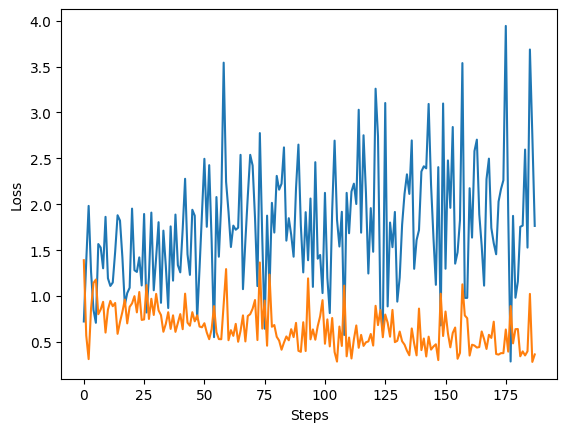

In [15]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(G_train_loss_list)
plt.plot(D_train_loss_list)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

### Generate and save images
아래 코드는 모델로부터 이미지를 생성하고 이를 확인하는 코드입니다.

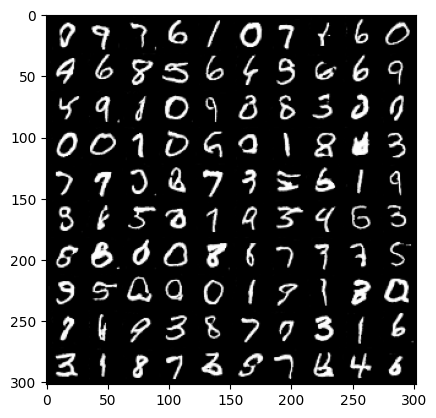

In [16]:
from torchvision.utils import make_grid

G.eval()

n_samples = 100

with torch.no_grad():
  z = torch.randn(n_samples, 100).to(DEVICE)
  x_hat = G(z)

img = make_grid(x_hat, nrow=10, normalize=True, value_range=(-1., 1.)).permute(1, 2, 0).cpu().data.numpy()

imshow(img, cmap='gray')